# Helpers.py

In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np

@dataclass
class Peak:
    center: float
    height: float
    width: float
    shape: str

    def __str__(self):
        return f"Peak in {self.center}, height {self.height} & width {self.width} of {self.shape} shape"

    def evaluate(self, ws):
        values = self.height - (ws / self.width - self.center) ** 2
        # We forbid < 0 values
        return np.where(values < 0, 0, values)

    def plot(self, ws):
        values = self.evaluate(ws)
        plt.plot(ws, values, 'g')
        plt.plot(-ws, values, 'g')

    @classmethod
    def evaluate_all(cls, peaks, ws):
        return np.max([peak.evaluate(ws) for peak in peaks], axis=0)

    @staticmethod
    def integral(f, ws):
        dw = ws[1] - ws[0]  # assumed constant
        return np.sum(dw * f)

    @staticmethod
    def aggregate(peaks, ws):
        values = Peak.evaluate_all(peaks, ws)
        # Normalize (ToDo: investigate as it can make us go below 1/2)
        return values / Peak.integral(values, ws) / 2 # since we only focus on w >= 0)


class Evaluator:
    @staticmethod
    def show(model, X, y, ws):
        y_pred = model.predict(np.array([X, ]))[0]
        plt.plot(ws, y)
        plt.plot(ws, y_pred)
        plt.show()

# Data Generation

{'U': 0.5868684290101023, 'peaks': [Peak(center=0.29343421450505114, height=0.2990095764521463, width=1.3112895363779875, shape='quadratic')]}
(-0.1601261208431297-0.4082304863761227j)



0.5


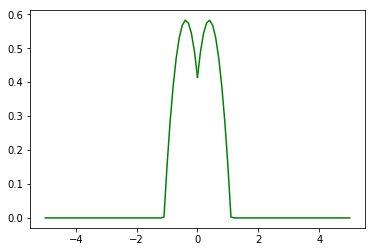

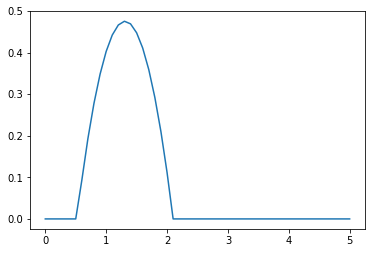

In [ ]:
# Data Generation
## Script generating spectral density functions with different levels of noise

import numpy as np
from numpy.random import uniform, random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
# from helpers import Peak
import pickle

U_max = 5
dw = 0.1

Nw = int(U_max / dw)
ws = np.linspace(0, U_max, Nw + 1)
ws

def generate_spectral_density(ws, U_max, seed=None):
    """ Returns an array of A[i] containing the values of A at ws[i] """
    if seed is not None:
        np.random.seed(seed)
    peaks = []
    # Interaction strength
    U = uniform(0, U_max)
    # Metallic or insulator
    metallic = random() < (U_max - U) / U_max
    if metallic:
        peaks.append(Peak(
            0,
            0.5,
            min(2, 4 / U**2),
            'quadratic'
        ))
    # Generating first peak
    peaks.append(Peak(
        U / 2,
        uniform(0.1, 0.4),
        uniform(0.5, 2),
        'quadratic'
    ))

    # Aggregate all the peaks
    return Peak.aggregate(peaks, ws), {
        'U': U,
        'peaks': peaks
    }

A, params = generate_spectral_density(ws, U_max)
print(params)
plt.plot(ws, A, 'g')
plt.plot(-ws, A, 'g')

def compute_green(A, ws, n):
    """ Computes Integral(A(w) / (iw_n - w)) for a given n"""
    return complex(Peak.integral(A / (1j * (2 * n + 1) - ws), ws))

print(compute_green(A, ws, 0))

def compute_greens(A, ws, nw_cutoff=300):
    """ Computes Integral(A(w) / (iw_n - w)) for all n below nw_cutoff"""
    ReG, ImG = [], []
    for n in range(nw_cutoff):
        z = compute_green(A, ws, n)
        ReG.append(z.real)
        ImG.append(z.imag)
    return ReG + ImG

compute_greens(A, ws, nw_cutoff=5)

## Full generation of data

# ToDo: If model finds data back successfully => add noise !!

N_samples = 100000

np.random.seed(42)  # for reproductibility
results = []
for _ in trange(N_samples):
    A, params = generate_spectral_density(ws, U_max)
    # print(np.sum(A) * dw)
    results.append({
        'params': params,
        'greens': compute_greens(A, ws)
    })

values = Peak.aggregate(results[0]['params']['peaks'], ws)
print(Peak.integral(values, ws))
plt.figure()
plt.plot(ws, values)
plt.show()

with open('data.pkl', 'wb+') as out:
    pickle.dump(results, out)

# Neural Network

In [ ]:
import numpy as np
import pickle
from tqdm.notebook import tqdm
# from helpers import Peak, Evaluator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import History
from keras.callbacks import TensorBoard

with open('data.pkl', 'rb') as inp:
    data = pickle.load(inp)
data[0]

############ Read normalize and prepare the INPUT DATA
X = []
for datum in tqdm(data):
    X.append(datum['greens'])
X = np.array(X)
X.shape

## META PARAMETERS
layers = [1024, 1024, 512, 512, 1024, 1024]  # nb of neurons of each layer
nb_epochs = 50
name = 'initial'

## Variable to save the intermediate results
history = History()

########## Creation of the optimizer (adam) and the model 
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()
# 2*N = nb of Re(G(iw_n)) and Im(G(iw_n)) = X.shape[1]
model.add(Dense(units=layers[0], input_dim=X.shape[1]))  
for nb_neurons in layers[1:]:
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=nb_neurons))
model.add(Activation('relu'))  # sigmoid, softmax, relu
print("The model has been initiated with Sequential.")

########## Activate TensorBord in order to observe the evolution of the training live
tbCallBack = TensorBoard(log_dir='./TensorBoard/' + name, histogram_freq=0, write_graph=True, write_images=True)

############ Read normalize and prepare the OUTPUT DATA
y = []
for datum in tqdm(data):
    # Forward U_max in data generation
    ws = np.linspace(0, 5, layers[-1])
    density = Peak.aggregate(datum['params']['peaks'], ws)
    # print(Peak.integral(density, ws))
    y.append(density)
y = np.array(y)
print(y.shape)

## Train / Validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

######### Compile the model
model.compile(loss='mean_absolute_error', # 'kullback_leibler_divergence',
        optimizer=adam,
        metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, 
                    epochs=nb_epochs,
                    initial_epoch=0,
                    batch_size=128,
                    validation_data=(X_test, y_test)) 
                    # callbacks=[tbCallBack])

######## Save the results
output_dir = 'output_'
# f_handle = open(output_dir + str(name)+'_mae.csv', 'a')
# np.savetxt(f_handle, history.history['mean_absolute_error'])
# f_handle.close()
# f_handle = open(output_dir + str(name)+'_val_mae.csv', 'a')
# np.savetxt(f_handle, history.history['val_mean_absolute_error'])
# f_handle.close()

plt.figure()
plt.plot(history.history['mean_absolute_error'], label='Train')
plt.plot(history.history['val_mean_absolute_error'], label='Test')
plt.legend()
plt.show()

model.save(output_dir + str(name)+'_model.h5')
model.save_weights(output_dir + str(name)+'_weights.h5')

import matplotlib.pyplot as plt
class Evaluator2:
    @staticmethod
    def show(model, X, y, ws):
        y_pred = model.predict(np.array([X, ]))[0]
        plt.plot(ws, y)
        plt.plot(ws, y_pred)
        plt.show()
        
for i in range(3):
    Evaluator2.show(model, X_train[i], y_train[i], ws)
    Evaluator2.show(model, X_test[i], y_test[i], ws)

Using TensorFlow backend.



The model has been initiated with Sequential.



(100000, 1024)
Train on 67000 samples, validate on 33000 samples
Epoch 1/50
67000/67000 [==============================] - 51s 760us/step - loss: 0.0749 - mean_absolute_error: 0.0749 - val_loss: 0.0551 - val_mean_absolute_error: 0.0551
Epoch 2/50
67000/67000 [==============================] - 43s 638us/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0965 - val_mean_absolute_error: 0.0965
Epoch 3/50
67000/67000 [==============================] - 45s 666us/step - loss: 0.0393 - mean_absolute_error: 0.0393 - val_loss: 0.1137 - val_mean_absolute_error: 0.1137
Epoch 4/50
67000/67000 [==============================] - 51s 761us/step - loss: 0.0347 - mean_absolute_error: 0.0347 - val_loss: 0.1343 - val_mean_absolute_error: 0.1343
Epoch 5/50
67000/67000 [==============================] - 54s 808us/step - loss: 0.0321 - mean_absolute_error: 0.0321 - val_loss: 0.0675 - val_mean_absolute_error: 0.0675
Epoch 6/50
67000/67000 [==============================] - 51s 762us/step - loss

67000/67000 [==============================] - 49s 736us/step - loss: 0.0216 - mean_absolute_error: 0.0216 - val_loss: 0.0498 - val_mean_absolute_error: 0.0498
Epoch 49/50
18816/67000 [=======>......................] - ETA: 29s - loss: 0.0217 - mean_absolute_error: 0.0217

# Convolutional Network

In [ ]:
import numpy as np
import pickle
from tqdm.notebook import tqdm
# from helpers import Peak, Evaluator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import History
from keras.callbacks import TensorBoard

with open('data.pkl', 'rb') as inp:
    data = pickle.load(inp)
data[0]

############ Read normalize and prepare the INPUT DATA
X = []
for datum in tqdm(data):
    X.append(datum['greens'])
X = np.array(X)
print(X.shape)

## META PARAMETERS
layers = [1024, 128, 64, 1024, 256]  # nb of neurons of each layer
nb_epochs = 500
name = 'initial'

## Variable to save the intermediate results
history = History()

########## Creation of the optimizer (adam) and the model 
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()
# 2*N = nb of Re(G(iw_n)) and Im(G(iw_n)) = X.shape[1]
input_shape=(X.shape[1], 1)
for i in range(1, len(layers) - 2):
    nb_neurons = layers[i]
    print(nb_neurons, layers[i - 1])
    model.add(Conv1D(nb_neurons, 2, strides=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=(1)))
    model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=layers[-2], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=layers[-1]))
model.add(Activation('relu'))  # sigmoid, softmax, relu
print("The model has been initiated with Sequential.")

########## Activate TensorBord in order to observe the evolution of the training live
tbCallBack = TensorBoard(log_dir='./TensorBoard/' + name, histogram_freq=0, write_graph=True, write_images=True)

############ Read normalize and prepare the OUTPUT DATA
y = []
for datum in tqdm(data):
    # Forward U_max in data generation
    ws = np.linspace(0, 5, layers[-1])
    density = Peak.aggregate(datum['params']['peaks'], ws)
    # print(Peak.integral(density, ws))
    y.append(density)
y = np.array(y)
print(y.shape)

## Train / Validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# For Conv1D layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

######### Compile the model
model.compile(loss='mean_absolute_error', # 'kullback_leibler_divergence',
        optimizer=adam,
        metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, 
                    epochs=nb_epochs,
                    initial_epoch=0,
                    batch_size=128,
                    validation_data=(X_test, y_test), 
                    callbacks=[tbCallBack])

######## Save the results
output_dir = 'output_'
# f_handle = open(output_dir + str(name)+'_mae.csv', 'a')
# np.savetxt(f_handle, history.history['mean_absolute_error'])
# f_handle.close()
# f_handle = open(output_dir + str(name)+'_val_mae.csv', 'a')
# np.savetxt(f_handle, history.history['val_mean_absolute_error'])
# f_handle.close()

plt.figure()
plt.plot(history.history['mean_absolute_error'], label='Train')
plt.plot(history.history['val_mean_absolute_error'], label='Test')
plt.legend()
plt.show()

model.save(output_dir + str(name)+'_model.h5')
model.save_weights(output_dir + str(name)+'_weights.h5')

import matplotlib.pyplot as plt
class Evaluator2:
    @staticmethod
    def show(model, X, y, ws):
        y_pred = model.predict(np.array([X, ]))[0]
        plt.plot(ws, y)
        plt.plot(ws, y_pred)
        plt.show()
        
for i in range(3):
    Evaluator2.show(model, X_train[i], y_train[i], ws)
    Evaluator2.show(model, X_test[i], y_test[i], ws)

In [ ]:
layers = [1024, 256, 128, 1024, 256]  # nb of neurons of each layer
# epoch 500
# 524/524 [==============================] - 6s 12ms/step - loss: 0.0546 - mean_absolute_error: 0.0546 - val_loss: 0.0488 - val_mean_absolute_error: 0.0488

layers = [1024, 256, 256, 256, 1024, 256]  # nb of neurons of each layer
# No initial dense, 4 2 2
# epoch 150 -> stil not overfitting and decreasing
# 524/524 [==============================] - 11s 22ms/step - loss: 0.0608 - mean_absolute_error: 0.0608 - val_loss: 0.0638 - val_mean_absolute_error: 0.0638




# Dense + CNN

In [ ]:
import numpy as np
import pickle
from tqdm.notebook import tqdm
# from helpers import Peak, Evaluator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, Reshape
from keras.optimizers import Adam
from keras.callbacks import History
from keras.callbacks import TensorBoard

with open('data.pkl', 'rb') as inp:
    data = pickle.load(inp)
data[0]

############ Read normalize and prepare the INPUT DATA
X = []
for datum in tqdm(data[:100]):
    X.append(datum['greens'])
X = np.array(X)
print(X.shape)

## META PARAMETERS
layers = [1024, 128, 64, 1024, 256]  # nb of neurons of each layer
nb_epochs = 50
name = 'initial'

## Variable to save the intermediate results
history = History()

########## Creation of the optimizer (adam) and the model 
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()
# 2*N = nb of Re(G(iw_n)) and Im(G(iw_n)) = X.shape[1]
input_shape=(X.shape[1], 1)
model.add(Dense(units=layers[0], input_dim=X.shape[1]))  
model.add(Dropout(0.5))
model.add(Reshape(target_shape=(layers[0], 1)))
for i in range(1, len(layers) - 2):
    nb_neurons = layers[i]
    print(nb_neurons, layers[i - 1])
    model.add(Conv1D(nb_neurons, 2, strides=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=(1)))
    model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=layers[-2], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=layers[-1]))
model.add(Activation('relu'))  # sigmoid, softmax, relu
print("The model has been initiated with Sequential.")

########## Activate TensorBord in order to observe the evolution of the training live
tbCallBack = TensorBoard(log_dir='./TensorBoard/' + name, histogram_freq=0, write_graph=True, write_images=True)

############ Read normalize and prepare the OUTPUT DATA
y = []
for datum in tqdm(data[:100]):
    # Forward U_max in data generation
    ws = np.linspace(0, 5, layers[-1])
    density = Peak.aggregate(datum['params']['peaks'], ws)
    # print(Peak.integral(density, ws))
    y.append(density)
y = np.array(y)
print(y.shape)

## Train / Validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# For Conv1D layer
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

######### Compile the model
model.compile(loss='mean_absolute_error', # 'kullback_leibler_divergence',
        optimizer=adam,
        metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, 
                    epochs=nb_epochs,
                    initial_epoch=0,
                    batch_size=128,
                    validation_data=(X_test, y_test)) 
                    # callbacks=[tbCallBack])

######## Save the results
output_dir = 'output_'
# f_handle = open(output_dir + str(name)+'_mae.csv', 'a')
# np.savetxt(f_handle, history.history['mean_absolute_error'])
# f_handle.close()
# f_handle = open(output_dir + str(name)+'_val_mae.csv', 'a')
# np.savetxt(f_handle, history.history['val_mean_absolute_error'])
# f_handle.close()

plt.figure()
plt.plot(history.history['mean_absolute_error'], label='Train')
plt.plot(history.history['val_mean_absolute_error'], label='Test')
plt.legend()
plt.show()

model.save(output_dir + str(name)+'_model.h5')
model.save_weights(output_dir + str(name)+'_weights.h5')

import matplotlib.pyplot as plt
class Evaluator2:
    @staticmethod
    def show(model, X, y, ws):
        y_pred = model.predict(np.array([X, ]))[0]
        plt.plot(ws, y)
        plt.plot(ws, y_pred)
        plt.show()
        
for i in range(3):
    Evaluator2.show(model, X_train[i], y_train[i], ws)
    Evaluator2.show(model, X_test[i], y_test[i], ws)